In [ ]:
!pip install SpeechRecognition pydub librosa torch torchvision torchaudio scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sample_sentence.wav to sample_sentence (1).wav


Transcript Extraction

In [ ]:
import speech_recognition as sr

audio_file_path = 'sample_sentence.wav'

recognizer = sr.Recognizer()
with sr.AudioFile(audio_file_path) as source:
    recognizer.adjust_for_ambient_noise(source)
    audio_data = recognizer.record(source)

try:
    text = recognizer.recognize_google(audio_data)
    print("Extracted Transcript:\n", text)
except sr.UnknownValueError:
    print("Could not understand audio")
except sr.RequestError as e:
    print(f"API request error: {e}")


Extracted Transcript:
 audio for speech recognition testing


Waveform Plot

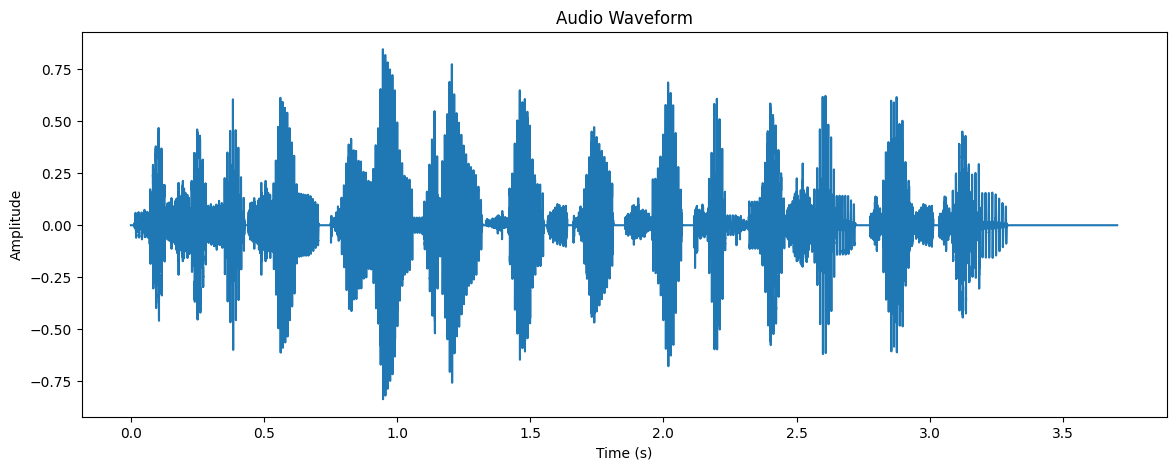

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

y, sr = librosa.load(audio_file_path, sr=None)
times = np.arange(len(y)) / sr

plt.figure(figsize=(14, 5))
plt.plot(times, y)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [ ]:
from google.colab import files
import zipfile
import os

# Upload your zipped audio dataset (yes/no folders inside)
uploaded = files.upload()

# Extract it
zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('audio')

# Check structure
os.listdir('audio')


Saving audio_data.zip to audio_data (1).zip


['audio_data']

Feature Extraction Function

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def extract_features(file, sr=16000, n_mfcc=20):
    y, _ = librosa.load(file, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    return np.concatenate([mfcc_mean, mfcc_std])


Prepare Data

In [ ]:
features, labels = [], []

for label in os.listdir('audio/audio_data'):
    folder = os.path.join('audio/audio_data', label)
    if os.path.isdir(folder):
        for f in os.listdir(folder):
            if f.endswith('.wav'):
                path = os.path.join(folder, f)
                features.append(extract_features(path))
                labels.append(label)

features = np.array(features)
labels = np.array(labels)

le = LabelEncoder()
y = le.fit_transform(labels)

scaler = StandardScaler()
X = scaler.fit_transform(features)

print("Classes:", le.classes_)
print("Feature shape:", X.shape)


Classes: ['no' 'yes']
Feature shape: (30, 40)


 Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


 Define & Train MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class AudioMLP(nn.Module):
    def __init__(self, input_dim, hidden=64, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = AudioMLP(input_dim=X_train.shape[1], num_classes=len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    model.eval()
    preds = model(X_test_t).argmax(dim=1)
    acc = (preds == y_test_t).float().mean().item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Test Acc: {acc:.4f}")


Epoch 1/10 - Loss: 0.7462 - Test Acc: 0.6667
Epoch 2/10 - Loss: 0.7252 - Test Acc: 0.6667
Epoch 3/10 - Loss: 0.6301 - Test Acc: 0.5000
Epoch 4/10 - Loss: 0.6505 - Test Acc: 0.5000
Epoch 5/10 - Loss: 0.6687 - Test Acc: 0.5000
Epoch 6/10 - Loss: 0.5819 - Test Acc: 0.5000
Epoch 7/10 - Loss: 0.5851 - Test Acc: 0.5000
Epoch 8/10 - Loss: 0.5721 - Test Acc: 0.5000
Epoch 9/10 - Loss: 0.5885 - Test Acc: 0.5000
Epoch 10/10 - Loss: 0.5643 - Test Acc: 0.3333


 Predict on sample_sentence.wav

In [ ]:
model.eval()
sample_features = extract_features('sample_sentence.wav')
sample_features_scaled = scaler.transform([sample_features])
sample_tensor = torch.tensor(sample_features_scaled, dtype=torch.float32)
pred_label = model(sample_tensor).argmax(dim=1).item()
print("Predicted Label:", le.inverse_transform([pred_label])[0])


Predicted Label: no
